# 3D Ising model exploration

## Introduction

##### The Ising model

The Ising model is a simplified model of ferromagnetic materials. The model has N atoms described by their spin defined by a binary variable equal to 1 or -1. Spins are located on a D-dimensional square grid. In this notebook we will consider the 3D version where spins are arranged on a cubic lattice.

Spins interact with their nearest neighbours, and the energy of a configuration
is described by the Hamiltonian

$$
E = -J \sum_{\langle i,j \rangle} s_i s_j,
$$

where:

- J is the strength of ferromagnetic interaction
- the sum runs over all pair (i,j) that are nearest neighbours 

---
##### Boltzmann distribution
At thermal equilibrium, the probability of observing a given spin configuration
\(S\) in the Ising model is given by the Boltzmann distribution

$$
P_B(S) = \frac{1}{Z} \exp\!\left( -\frac{E(S)}{T} \right),
$$

where

- \(E(S)\) is the energy of configuration \(S\),
- \(T\) is the temperature,
- \(Z\) is the **partition function**

$$
Z = \sum_{S} \exp\!\left( -\frac{E(S)}{T} \right),
$$

which ensures that all probabilities sum to 1.

This distribution favours configurations with lower energy (meaning aligned spins),
and suppresses configurations with misaligned neighbours.

---
##### Monte Carlo and Metropolis algorithm
Because the number of possible configurations grows exponentially with system size, direct enumeration becomes impossible.
Instead, we rely on **Markov Chain Monte Carlo** to generate representative
spin configurations according to the Boltzmann distribution:

$$
P(S) \propto e^{-E(S)/T}.
$$

The Metropolis algorithm, is used to propose local spin flips
and accept or reject them based on the energy change:

$$
p_{\text{acc}} = \min\!\left(1, \; e^{-(E_{\text{new}} - E_{\text{old}})/T}\right).
$$

This produces a sequence of configurations that, after equilibration, represent thermal samples
from the 3D Ising model at temperature \(T\).

---
#### Goals of the Project

The purpose of this notebook is to implement and explore the 3D Ising model using the Monte Carlo
methods. We will define the model, simulate its behaviour for different parameters, and analyse how key observables depend on these parameters. We will mainly study how the energy and magnetization will depend on the temperature, number of monte carlo steps or the total number of spins.

Our main research question is:

**How does the magnetization vary with temperature for different system sizes in the 3D Ising model?**

---
Note: for most of the graphs involving plotting the magnetization value we will use the absolute value of magnetization as we are mainly interested if the system will enter the ferromagnetic or paramagnetic stage.

Let's import the packages we will need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import seaborn as sns
from math import exp

## Defining the functions needed for successful simulation

Let's define the energy calculation function for our 3D model. We will use nearest neighbours for each spin which involve neighbours in the x, y and z direction.

The Hamiltonian of the 3D Ising model with coupling constant $J$ is:

$$
E = -J \sum_{\langle i,j \rangle} s_i s_j,
$$

We sum only over the positive directions o avoid double-counting:

$$
E = -J \sum_{i,j,k}
\left(
s_{i,j,k}\,s_{i+1,j,k}
+ s_{i,j,k}\,s_{i,j+1,k}
+ s_{i,j,k}\,s_{i,j,k+1}
\right).
$$

We implement periodic boundary conditions using modulo indexing:

$$
(i+1) \rightarrow (i+1)\bmod L,\qquad
(j+1) \rightarrow (j+1)\bmod L,\qquad
(k+1) \rightarrow (k+1)\bmod L.
$$


In [2]:
def energy(state, J):
    L = state.shape[0]
    e = 0.0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                s = state[i, j, k]
                e -= J * s * state[(i + 1) % L, j, k]
                e -= J * s * state[i, (j + 1) % L, k]
                e -= J * s * state[i, j, (k + 1) % L]
    return e

We will also implement a function calculating **local energy change**. This is due to the fact that recomputing the total energy of the entire system after every attempted spin flip is very costly when flipping a single spin only affects the six nearest-neighbour interactions.

$$
\Delta E = E_{\text{new}} - E_{\text{old}}
= 2 J s_{i,j,k} \sum_{\text{nearest neighbours}} s_{\text{nn}} .
$$

This turns each Metropolis step into an $\mathcal{O}(1)$ operation instead of $\mathcal{O}(L^3)$, dramatically improving performance.

In [3]:
def delta_energy(state, i, j, k, J):
    L = state.shape[0]
    s = state[i, j, k]
    nn = (
        state[(i+1) % L, j, k] +
        state[(i-1) % L, j, k] +
        state[i, (j+1) % L, k] +
        state[i, (j-1) % L, k] +
        state[i, j, (k+1) % L] +
        state[i, j, (k-1) % L]
    )
    return 2 * J * s * nn

Now, let's define the Metropolis acceptance function that will evaluate whether the flip of a spin should be accepted. We compare the
**old** energy $E_{\text{old}}$ with the **new** energy $E_{\text{new}}$ at
temperature $T$.

The Metropolis acceptance probability is

$$
p_{\text{acc}} =
\min\!\left(1,\;\exp\!\left[-\frac{E_{\text{new}} - E_{\text{old}}}{T}\right]\right).
$$

The rules are:

- If $E_{\text{new}} < E_{\text{old}}$ we **always** accept the move.
- If $E_{\text{new}} > E_{\text{old}}$, we accept the move with probability  $\exp\!\left[-(E_{\text{new}} - E_{\text{old}})/T\right]$.


In [4]:
def metropolis(e_old, e_new, T):
    if e_new < e_old:
        return True
    else:
        if np.random.random() < exp((e_old - e_new) / T):
            return True
        return False

Now let's define the **flip and magnetization functions**.

Each spin has either a +1 or -1 value. The **flip function** simply switches the sign of the spin value:

$$
s_{i,j,k} \;\longrightarrow\; -s_{i,j,k},
$$

The **magnetization per spin** is defined as the average of all spins in the
system:

$$
m = \frac{1}{N} \sum_{i,j,k} s_{i,j,k},
$$

In [5]:
def flip(state, i, j, k):
    state[i, j, k] = -state[i, j, k]

def magnetization(state):
    return np.sum(state) / state.size

## Simulation part

### Example simulation
First let's perform an example simulation to get the idea of how the model works for some standard parameters. Later on we will move to actual testing various combinations.

We first chose the following simulation parameters:

- **side** – linear size of the cubic lattice.  
  For example, side = 10 gives a lattice of (10^3 = 1000) spins.

- **T** – temperature

- **J** – coupling constant.  
  For \(J > 0\) the interaction is ferromagnetic (neighbouring spins prefer to align).

- **nstep** – number of Monte Carlo steps in the simulation.

- **seed** – random seed used to initialise the random number generator,  
  so that the simulation is reproducible.


In [6]:
side = 10
t = 2
J = 1.0  
nstep = 50000
seed = 67  

We begin the simulation by generating a random initial spin configuration for
the 3D lattice. To visualize this 3D configuration, we display the middle 2D slice of the lattice.

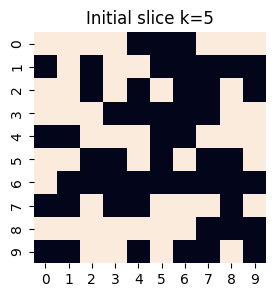

In [7]:
state = 2 * np.random.randint(2, size=(side, side, side)) - 1

plt.figure(figsize=(3, 3))
mid = side // 2
sns.heatmap(state[:, :, mid], vmin=-1, vmax=1, cbar=False)
plt.title(f"Initial slice k={mid}")
plt.show()

We now define the Metropolis Monte Carlo simulation function.  
Starting from the initial configuration, we repeatedly propose flipping a randomly chosen spin.

For each Monte Carlo step:

1. Select a random spin
2. Compute the local energy change
3. Accept the flip with probability
$$
p = \min\left(1, e^{-\Delta E / T}\right)
$$
4. If accepted, update the spin and update the total energy
$$
E \leftarrow E + \Delta E
$$
and the total magnetization
$$
M \leftarrow M - 2\, s_{i,j,k}
$$
5. Record the energy and magnetization per spin


In [8]:
def run_simulation_fast(state, side, t, J, nstep, seed):
    E = energy(state, J)
    M = np.sum(state)
    e_history = []
    m_history = []
    np.random.seed(seed)

    for istep in range(nstep):
        i = np.random.randint(side)
        j = np.random.randint(side)
        k = np.random.randint(side)
        dE = delta_energy(state, i, j, k, J)
        if dE < 0 or np.random.random() < np.exp(-dE / t):
            s_old = state[i, j, k]
            state[i, j, k] = -s_old
            E += dE
            M += -2 * s_old
        e_history.append(E / state.size)
        m_history.append(M / state.size)
    return e_history, m_history, state

Let's run an example simulation and plot the Energy and magnetization vs step to see the results.

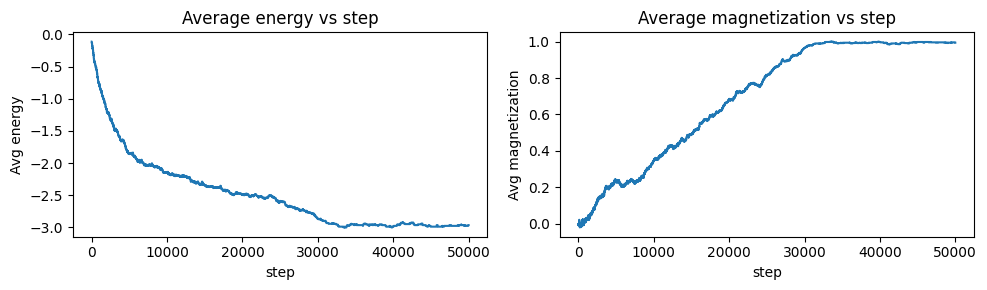

In [9]:
e_hist, m_hist, final_state = run_simulation_fast(
    state, side, t, J, nstep, seed
)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].plot(e_hist)
axes[0].set_xlabel("step")
axes[0].set_ylabel("Avg energy")
axes[0].set_title("Average energy vs step")

axes[1].plot(m_hist)
axes[1].set_xlabel("step")
axes[1].set_ylabel("Avg magnetization")
axes[1].set_title("Average magnetization vs step")

plt.tight_layout()
plt.show()

From the two plots we observe that the system equilibrates after roughly 30,000
Monte Carlo steps. The average energy curve decreases rapidly at first as the
initially random configuration moves toward lower energy states and then
stabilizes, indicating that equilibrium has been reached.   

At the same time, the magnetization
decreases to -1, showing that the system has entered a ferromagnetic state (vast majority of spins are alligned). After equilibration, both quantities
fluctuate around steady values, consistent with sampling from the Boltzmann distribution.
This behaviour is expected at low temperature, since spin flips that increase the energy are almost always rejected by the Metropolis algorithm.

Let's now check the average energy and magnetization for all of the steps after removing the first half of them. Those can be considered the equilibrium values.

In [10]:
cut = int(nstep/2)
e_sel = e_hist[cut:]
m_sel = m_hist[cut:]

avE = np.mean(e_sel)
avM = np.mean(m_sel)

print("Average energy:", avE)
print("Average magnetization:", avM)


Average energy: -2.91169696
Average magnetization: 0.97281264


### Parameters exploration

#### Energy and Magnetization vs temperature
We now move to exploring the different variations of parameters and relationships between different variables. Let's first explore how the average energy and magnetization changes with temperature value for an example L = 10. We set the J constant to 1 for easier analysis and number of steps to 100000 to analyse the whole process extensively.

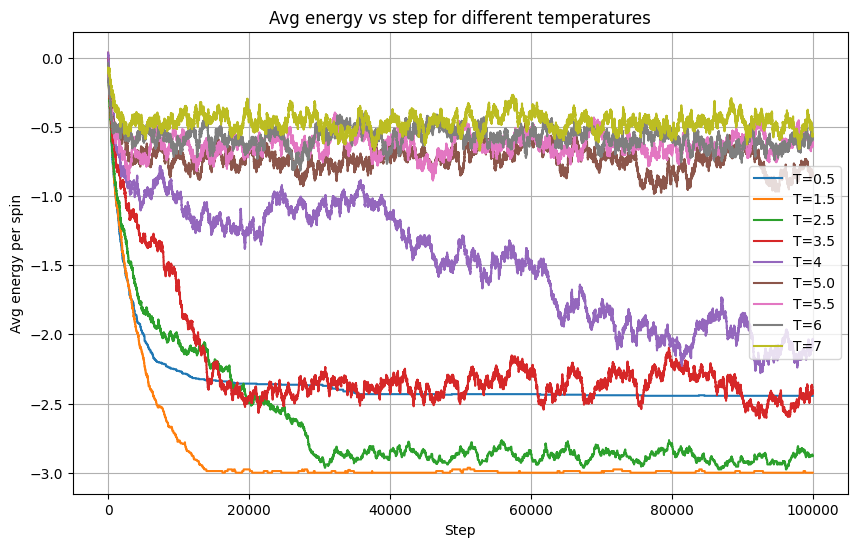

In [11]:
side = 10
J = 1.0
nstep = 100000
seed = 67
temps = [0.5, 1.5, 2.5, 3.5, 4 ,5.0, 5.5, 6, 7]

plt.figure(figsize=(10, 6))
final_states = {}

for t in temps:
    state = 2 * np.random.randint(2, size=(side, side, side)) - 1

    e_hist, m_hist, final_state = run_simulation_fast(
        state, side, t, J, nstep, seed
    )

    plt.plot(e_hist, label=f"T={t}")
    final_states[t] = final_state
    

plt.xlabel("Step")
plt.ylabel("Avg energy per spin")
plt.title("Avg energy vs step for different temperatures")
plt.legend()
plt.grid(True)
plt.show()


When the simulation begins, the system is at a random
configuration, which corresponds to a high energy, disordered state. As the Metropolis
algorithm progresses, the system moves toward equilibrium.

We can observe that for:

* **Lower temperatures**  
  The energy rapidly decreases and approaches lower values.  
  This reflects the formation of large ordered domains. The system moves toward
  a nearly fully aligned state.

* **High temperatures**  
  Initially the energy decreases, but still remains close to zero and fluctuates around a steady value. Here the thermal disorder dominates, the spins remain mostly uncorrelated,
  and the system does not develop long-range order.

Note: We consider low temperatures for T = 4 or less and high temperatures for T = 5 or more. We will explore the values from 4 to 5 in a second as those values are close to the critical temperature ~4.5.

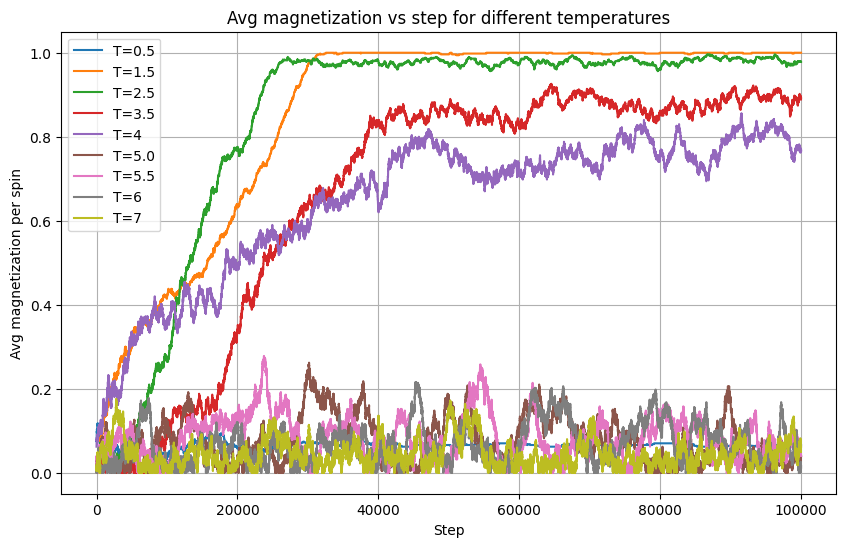

In [12]:
plt.figure(figsize=(10, 6))

for t in temps:
    state = 2 * np.random.randint(2, size=(side, side, side)) - 1

    e_hist, m_hist, final_state = run_simulation_fast(
        state, side, t, J, nstep, seed
    )
    plt.plot(np.abs(m_hist), label=f"T={t}")

plt.xlabel("Step")
plt.ylabel("Avg magnetization per spin")
plt.title("Avg magnetization vs step for different temperatures")
plt.legend()
plt.grid(True)
plt.show()


At the beginning the system is in a random configuration so the initial magnetization value for all temperatures is 0. We can observe that for:

**Lower temperatures:**  
Magnetization grows steadily toward large values.  
At low temperature, the system minimizes energy by aligning spins, forming a
large ordered domain.

**Higher temperatures:**  
Magnetization fluctuates close to zero for the entire simulation.  
At high temperature thermal noise dominates, spins remain mostly disordered,   
and
the system does not develop any global allignment. This corresponds to the
paramagnetic phase.

Let's plot and example 2D side from the cube after the simulation for low (2) and high (6) temperature to see that for the high temperature the side will have aligned spin and for the high temperature, not aligned spins.

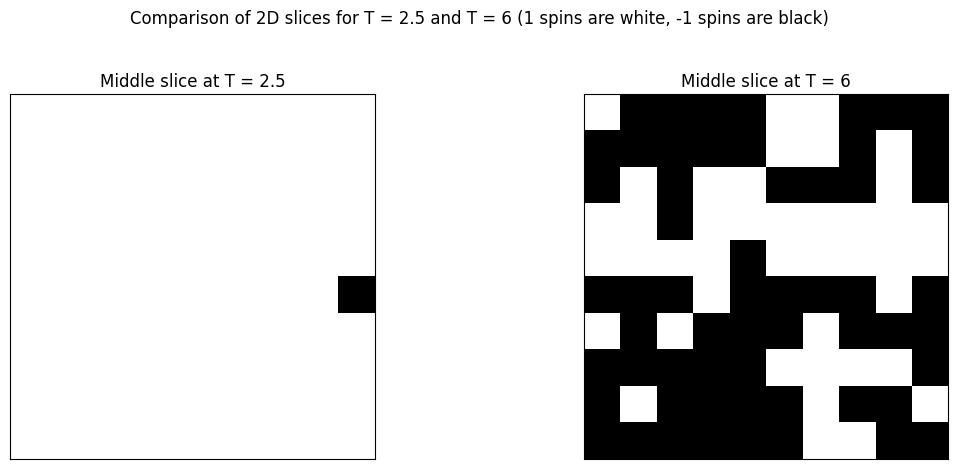

In [13]:
temps_to_show = [2.5, 6]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

mid = side // 2

for ax, T in zip(axes, temps_to_show):
    slice2D = final_states[T][mid, :, :]
    im = ax.imshow(slice2D, cmap="gray", vmin=-1, vmax=1)
    ax.set_title(f"Middle slice at T = {T}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Comparison of 2D slices for T = 2.5 and T = 6 (1 spins are white, -1 spins are black)")
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.show()


#### Magnetization behaviour near the critical temperature

The critical temperature/phase transition temperature for a 3D Ising system is known to be ~4.5.  
 Let's explore how the system will behave for temperatures close to that value. Let's continue the analysis with L = 10.

Text(0.5, 1.0, 'Magnetization vs step for critical-region temperatures')

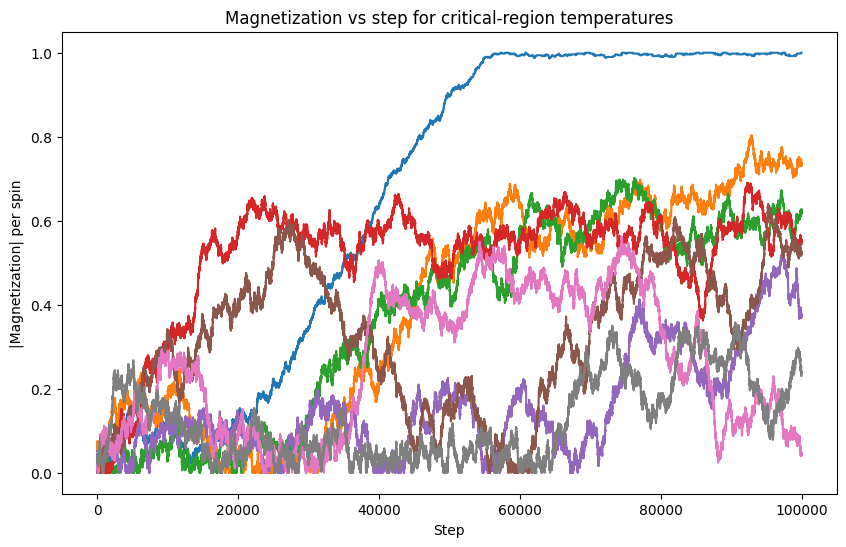

In [14]:
side = 10
J = 1.0
nstep = 100000
seed = 67
temps = [2,4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8]

plt.figure(figsize=(10, 6))

for t in temps:
    state = 2 * np.random.randint(2, size=(side, side, side)) - 1
    e_hist, m_hist, final_state = run_simulation_fast(state, side, t, J, nstep, seed)

    plt.plot(np.abs(m_hist), label=f"T={t}")

plt.xlabel("Step")
plt.ylabel("|Magnetization| per spin")
plt.title("Magnetization vs step for critical-region temperatures")


We included one curve with a temperature far from the critical one (T = 2) to strengthen the observation. The magnetization curves n the temperature range T ≈ 4.2–4.8 appear noisy and don't settle for a clear equilibrium value within the simulation time. This behaviour
is expected and can be explained by several physical effects:

**1. Critical slowing down**  
As the system approaches the phase transition, the rate at which domains grow
and reorganize becomes extremely slow. Thus, even after many Monte Carlo
steps the system has not developed a stable magnetization.

**2. Large fluctuations**  
Near the critical temperature, two competing effects fight:
the ferromagnetic coupling, which tries to align neighbouring spins into large
domains, and the thermal fluctuations, which try to randomise and break up
these domains. As a result, the magnetization exhibits large fluctuations: domains grow and collapse repeatedly,leading to strong variations in the measured magnetization.


**3. Trend relative to the critical point**  
Temperatures slightly below the critical value (T ≲ 4.5) tend to drift toward
larger magnetization values, whereas temperatures slightly above it
(T ≳ 4.5) tend to remain closer to zero. However, due to strong fluctuations,
the distinction is blurred compared to low or high temperatures.

#### Magnetization vs step for different values of N

Before moving on to our main research interest "Magnetization as a function of temperature, for different values of the number of spins N", let's check how will the magnetization value change plotted vs step for different sizes of the cube for a fixed temperature T = 1. This will help us to get more insights about how does the number of spins in our system influence other parameters.

Running simulation for L = 10 at T = 1
Running simulation for L = 20 at T = 1
Running simulation for L = 30 at T = 1
Running simulation for L = 50 at T = 1
Running simulation for L = 100 at T = 1
Running simulation for L = 200 at T = 1


/var/folders/cm/9hgr6tsn4nx0r2hqdh1_mt3h0000gn/T/ipykernel_81395/3676684414.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/janekpetsch/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


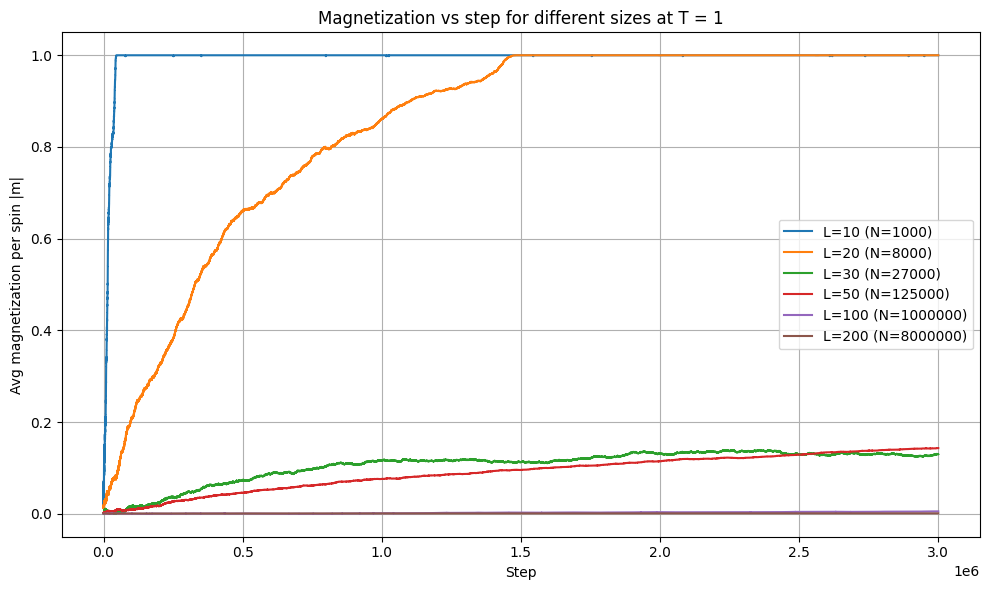

In [ ]:
J = 1.0
nstep = 3000000
seed = 67
T = 1       

sizes = [10, 20, 30, 50, 100, 200]

plt.figure(figsize=(10, 6))

for L in sizes:
    state = 2 * np.random.randint(2, size=(L, L, L)) - 1
    e_hist, m_hist, final_state = run_simulation_fast(state, L, T, J, nstep, seed)
    plt.plot(np.abs(m_hist), label=f"L={L} (N={L**3})")

plt.xlabel("Step")
plt.ylabel("Avg magnetization per spin |m|")
plt.title(f"Magnetization vs step for different sizes at T = {T}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The equilibrium
state at this temperature is fully ordered, with magnetization |m| ≈ 1.
However, we observe that only the smallest systems approach this value within the
simulation time eventhough we set the number of steps to be 3000000. This behaviour is expected. The number of spin–flip attempts scales linearly with
the total number of steps, whereas the system size scales as L³. As L increases,
a fixed number of Monte Carlo steps corresponds to far fewer sweeps, meaning
each spin is updated extremely rarely. 

This slow convergence is a result of critical slowing down, even far
below the critical temperature, because domain coarsening in the Metropolis
algorithm proceeds only through local updates. Close to the critical temperature the system would take even way more time to converge. To handle this issue, more efficient cluster algorithms exist, such as the
Wolff algorithm, which flips entire correlated spin clusters at once and
dramatically accelerates equilibration.

#### Magnetization vs temperature, for different values of the number of spins N